# References
[1] https://nirvan66.github.io/geoguessr.html
We took inspiration from this previous project and attempted to improve the results and collect more data. Our main contributions to the training portion of the project were:
- include creating a custom training loop and a custom loss function.
- Parallelizing the model itself with tensorflow distributed.
- Changing the model to use regression rather than classification to make the model more scalable with larger amounts of data.
- Hyperparameter tuning the model params such as the dropout rates
- Adding a learning rate scheduler to the training loop.

In the previous work the model was trained to predict a particular grid that a particular set of images was located at. They used categorical crossentropy loss to accomplish this. However, this approach is not scalable for large amounts of global data. This is because the more locations that you train the model on the more grids that the model will be able to predict. This will lead to a one hot encoded y vector of an immensely large size. Additionally, this does not punish the model for predicting a certain grid that is nowhere near the actual location of the image. We approached this problem by using regression rather than classification. Our results are comparable to the previous project, but there is more work to be done and model improvements for our approach to be viable. This leads us to our future work.

## Future Work
### Practical Approach to the Problem
One potential issue we found with using Mean Squared Error is that it uses Euclidean distance to calculate the error. When calculating the distance between latitude and longitude values you should not use the euclidean distance. Instead, you should use the haversine distance. You must take into account the curvature of the earth. Secondly, we used pretrained resnet weights and did not perform any fine-tuning due to our available recourses. If you finetune the model you should see improved results.

### Novel Approach to the Problem
First we must make a deeper network that will be able to retain patterns as we collect more data. This model will most likely need to be put into two main stages. The first stage should attempt to predict the region or country that the image is located in. The second stage should take this prediction as well as the image data and bounds of the predicted region and attempt to predict the more specific location of the image. We believe this will allow the model to better learn the magnitudes of the longitude and latitude values of the particular region and then be fine tuned with the second stage.
Additionally, we believe that the model could also be improved by using ocr on the images to extract any text within the image. With this text you could then feed it into a many-to-one model to predict the language of the text. You could take this prediction to use heuristics containing the regions or countries where the particular language is spoken. You could use these additional heuristics to improve the first proposed stage of the model that will predict the general region of the images.

# Download image data
The following cell downloads the Data tar file located in the team's Google Drive. This allows one to download all of the data necessary used for training and validating the model. After running the cell below, one should check the directory that they are in to verify that a directory and tar file name "Data" and "Data.tar" respectively appear. These files contain the images collected from the data scraping performed.

**(NOTE: If you receive an error that prevents you from accessing the Google Drive, rerun the cell once. If this does to fix the issue, please email Hunter Price for access information)** 

In [2]:
%load_ext autoreload
%autoreload 2
import gdown
import os
data_tar = 'Data.tar'
data_url = 'https://drive.google.com/uc?id=15yLCvIIQSxxdL4dropBICxkVhKYAL_gM'

if not os.path.exists(data_tar) and not os.path.exists('Data'):
    gdown.download(data_url, data_tar, quiet=False)
if not os.path.exists('Data'):
    !tar -xf Data.tar

Downloading...
From: https://drive.google.com/uc?id=15yLCvIIQSxxdL4dropBICxkVhKYAL_gM
To: /content/Data.tar
100%|██████████| 503M/503M [00:06<00:00, 73.8MB/s]


# Create CSV
The following could handles parsing through data directory and creating a CSV of the filenames and metadata. One must first specify the directory that contain the images. This variable is preset to 'Data', which accesses the directory downloaded in the cell above. Once a directory is specified, one can run the cell to download the dataset into a CSV file named "DataLabels.csv". Essentially, the code uses the directory names within the data directory to label the data accordingly. The code also filters out any image folders that do not contain all three images. Please verify that the CSV file has been properly created before continuing.

In [3]:
# importing the required packaged 
import pandas as pd
import sys
from functools import reduce

#Declared global variables
dir_name = 'Data'
myDict = {}
data_frame = pd.DataFrame()

#This function gets the pathnames to each of the images
def get_filepaths(directory):
    file_paths = []  # List which will store all of the full filepaths.
    count = 0
    
    # Walk the tree.
    print(" ")
    print("The following paths will not be included because they contain less than 3 directions:")
    for root, directories, files in os.walk(directory):
        if(len(files) == 3 or len(files) == 0):
            for filename in files:
                count += 1
                # Join the two strings in order to form the full filepath.
                filepath = os.path.join(root, filename)
                count, file_paths.append(filepath) 
        else:
            print(str(root))
    return count, file_paths

#This function parses the path names and extracts the information
def data_to_labels(dir_name):
    counted, file_paths = (get_filepaths(dir_name))
    file_paths_segmented = [f.split(os.path.sep) for f in file_paths]
    file_segmented2 = []

    for i, f in enumerate(file_paths_segmented):
        files = []
        for fi in f:
            files.append(fi.replace('_',',').split(','))

        files = reduce(lambda a,b:a+b, files)
        files.insert(0,file_paths[i])
        file_segmented2.append(files)    
        myDict["File " + str(i)] = files
    return myDict

#Main simply stores the information in a CSV. This process will be turned into a seperate function
def main():
    
    #Fill the dir_name string manually to run in notebook
    if(dir_name == ''):
        if(len(sys.argv) != 2):
            print('Please specify a directory or Define "dir_path" in the code')   
        else:
            print(f"Created a CSV file named DataLabels.csv")
            data_frame = (pd.DataFrame.from_dict(data_to_labels(str(sys.argv[1])),orient='columns')).T
            data_frame.columns = ['File Path', 'Data Folder', 'Grid Number', 'Min X', 'Min Y', 'Max X', 'Max Y','Latitude','Longitude','Angle','File Name'] 
            data_frame.to_csv('DataLabels.csv')
    else:
            print(f"Created a CSV file named DataLabels.csv")
            data_frame = (pd.DataFrame.from_dict(data_to_labels(dir_name),orient='columns')).T
            data_frame.columns = ['File Path', 'Data Folder', 'Grid Number', 'Min X', 'Min Y', 'Max X', 'Max Y','Latitude','Longitude','Angle','File Name'] 
            data_frame.to_csv('DataLabels.csv')
    
if __name__=="__main__" :
    main()


Created a CSV file named DataLabels.csv
 
The following paths will not be included because they contain less than 3 directions:
Data/39_-116.0_44.0_-114.0_46.0/45.5970459,-115.861618
Data/0_-124.552441_39.97720877884329_-124.0_45.08734407897483/40.07824520959485,-124.0863631072246


# Preprocessing The Data

This cell preprocesses the data in the CSV file created above. First, we use pandas to read the CSV file into a dataframe. After that, we seperate the images into groups of 3 separate directions(0°, 90°, and 180°) at the given position. Next, the numerical representations of the images are read into an input list for the model, X. We also collect the latitude and longitude values and grid value for training. Lastly, the data is normalized and split into training and validation data using a 0.8/0.2 split. 

In [4]:
import cv2

import pandas as pd
from cv2 import imread, resize
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import resample

BATCH = 128

# Function that calculates the center of a grid given the min and max point
def get_center_grid(row):
    min_vec = np.array([row['Min X'].iloc[0],row['Min Y'].iloc[0]])
    max_vec = np.array([row['Max X'].iloc[0],row['Max Y'].iloc[0]])
    vec = (max_vec - min_vec)/2 + min_vec
    return vec[1], vec[0]

# Read in the data
data = pd.read_csv('DataLabels.csv')

# Create a list containing a group of 3 files for all the files in data
data = [data[i:i+3] for i in range(0, len(data), 3)]

# Initialize the data vectors
dsize = (100, 200)
X = np.zeros((len(data),3,dsize[0],dsize[1],3))
Y = np.zeros((len(data),1)).astype(int)
loc = np.zeros((len(data),2))
grid_centers = np.zeros((len(data),2))

# Read in all images
print('# Reading in files')
print('     - Total # of data points:',len(data))
grid_center_dict = {}
for index,fileCluster in enumerate(data):
    X[index,0,:] = resize(imread(data[index]['File Path'][0+(index*3)]), dsize=(dsize[1],dsize[0]), interpolation=cv2.INTER_LANCZOS4)
    X[index,1,:] = resize(imread(data[index]['File Path'][1+(index*3)]), dsize=(dsize[1],dsize[0]), interpolation=cv2.INTER_LANCZOS4)
    X[index,2,:] = resize(imread(data[index]['File Path'][2+(index*3)]), dsize=(dsize[1],dsize[0]), interpolation=cv2.INTER_LANCZOS4)
    loc[index,:] = np.array([data[index]['Latitude'].iloc[0], data[index]['Longitude'].iloc[0]])
    Y[index,:]   = int(data[index]['Grid Number'].iloc[0])
    grid_centers[index,:] = np.array(get_center_grid(data[index]))
    grid_center_dict[int(data[index]['Grid Number'].iloc[0])] = np.array(get_center_grid(data[index]))

# Normalize the data by dividing by 255
print('# Normalizing data')
X = X / 255

# One hot encode the Y data
print('# One hot encoding data')
Y = tf.keras.utils.to_categorical(Y)


# Sample the data because it takes up too much ram
perc_to_keep = 0.5
print(f"# Sampling {perc_to_keep*100}% of the data")
X,Y,loc = resample(X,Y,loc, n_samples=int(len(X)*perc_to_keep), replace=False, stratify=Y, random_state=0)

# Train Test Split
print("# Splitting into train and validation data")
X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(X, Y, loc, test_size=0.2)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train,loc_train)).shuffle(1000).batch(BATCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test,loc_test)).shuffle(1000).batch(len(X_test))
grid_count = y_train.shape[1]

# Print out shapes of the data for sanity
print("# Shapes:")
print("     - X_train:", X_train.shape)
print("     - y_train:", y_train.shape)
print("     - X_test:", X_test.shape)
print("     - y_test:", y_test.shape)

print('# DONE')
# delete the original X, Y, and loc to save memory for computation
del X, Y, loc

# Reading in files
     - Total # of data points: 4880
# Normalizing data
# One hot encoding data
# Sampling 50.0% of the data
# Splitting into train and validation data
# Shapes:
     - X_train: (1952, 3, 100, 200, 3)
     - y_train: (1952, 243)
     - X_test: (488, 3, 100, 200, 3)
     - y_test: (488, 243)
# DONE


# Defining The Model

The following function get_model() defines the model used in the training below. The tensorflow strategy specifies how the model and dataset should be distributed over different workers and different gpus or cpus. In this project we use a mirrored strategy due to our limited recourses. For more information go to: https://www.tensorflow.org/api_docs/python/tf/distribute

In [5]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, Dense, Dropout, LSTM
from tensorflow.keras import optimizers

def get_model(inputShape=(3, 100, 200, 3), strategy = tf.distribute.MirroredStrategy()):
    '''
    The function is used to load or initialize a new model
    useRestnet : set to True to use pretrained frozen restnet model
                 set to False to use trainable CNN model
    inputShape: Shape of input image set
                (<numer-of-images>, <image-width>, <image-height>, <RGB-values>)
    gridCount: Number of ouput grids to predict on
    '''

    with strategy.scope():
      convnet = tf.keras.Sequential()

      # use restnet CNN
      restnet = ResNet50(include_top=False, weights='imagenet')

      # Freeze model
      restnet.trainable = False
      convnet.add(restnet)
      convnet.add(GlobalMaxPool2D())

      # Create the input layer
      inputs = tf.keras.Input(shape=inputShape)
      # Connect the CNN to an LSTM and send through some Dense Layers
      model_inp = TimeDistributed(convnet)(inputs)
      model_inp = LSTM(64)(model_inp)
      model_inp = Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform())(model_inp)
      model_inp = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform())(model_inp)
      model_inp = Dropout(.25)(model_inp)

      # Add the regression head
      model_cat = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform())(model_inp)
      model_cat = Dropout(.25)(model_cat)
      model_cat = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform())(model_cat)
      model_cat = Dense(2, activation='linear', kernel_initializer=tf.keras.initializers.GlorotUniform())(model_cat)
      model = tf.keras.Model(inputs, model_cat)

      return model


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Training
This cell handles setting all of the parameters for training the model and handles updating the weights from the custom loss function. First, we define a learning rate scheduler. We used several different parameters within the scheduler, and we have provided the best ones found below. We also choose to use the Adam optimizer to help increase accuracy. Next, we create the model, passing it the parameters that are used in the cell above, and define lists for holding the results. 

\

The functions defined below: 

\
**calc_loss(y_true, y_pred_cat, loc_true)** is our custom loss function used to determine how far our model's prediction was from the actual prediction. Currently, the loss function uses mean squared error  to determine how how far the grid value outputted was from the actual location. We have intentions to expand this loss function to include the curvature of Earth and other features to better predict the location of the images taken.

\
**train(batch)** uses the x, and true location values in the given batch, calls the calculate loss function with the information, and applies the gradient manually to the model. One important note is that training needs to be set to true because we are using Resnet.

\
**test(batch)** predicts the validation data within the training loop.

\
Each of these are broken into individual function in order to expand this network into a model that can better predict the location of a given image. For example, with this custom loss function, we could include more features like topology and potentially even use semenatic segmentation to distinguish objects within the image and perform an individual loss analysis on each.

In [6]:
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras.losses import mean_squared_error

# Set up optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=2.5e-05,
            decay_steps=1500,
            decay_rate=0.9)
OPT = optimizers.Adam(learning_rate=lr_schedule)
strategy = tf.distribute.MirroredStrategy()

# get the model
model = get_model(inputShape=(3, 100, 200, 3), strategy = strategy)

#Define lists for results
train_loss_results = []
val_loss_results = []

def calc_loss(y_pred_reg, loc_true):
    # Calculate loss
    loss = tf.reduce_mean(mean_squared_error(loc_true, y_pred_reg))
    return loss

@tf.function
def train(batch):
    x, y_true, loc_true = batch

    with tf.GradientTape() as tape:
        # Get model predictions
        y_pred_reg = model(x, training=True)

        # Calculate loss
        loss = calc_loss(y_pred_reg, loc_true)

    grads = tape.gradient(loss, model.trainable_weights)
    OPT.apply_gradients(zip(grads, model.trainable_weights))
    return loss

@tf.function
def test(batch):
    x, y_true, loc_true = batch
    y_pred_reg = model(x, training=False)
    loss = calc_loss(y_pred_reg, loc_true)
    return loss
  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

#Viewing the Model
The following cell can be used to see the architecture of the model used for the training.

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 100, 200, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 3, 2048)          23587712  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 64)                540928    
                                                                 
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

#Training Loop
The following cell is our training loop. The number of epochs can be changed to reduce the learning time. The training itself takes a batch from the dataset, performs all of the operations, appends the results, plots the results, and goes to the next epoch. The training is also timed.

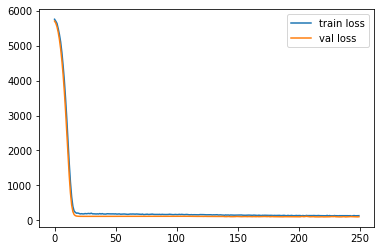

The Model Training Completed In:  3086.577168226242


In [8]:
import time
START = time.time()
EPOCHS = 250
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch}")
    model.reset_states()

    # init temporary variables
    epoch_loss_avg = tf.keras.metrics.Mean()

    # train on each batch
    for batch in train_dataset:
        loss_value = strategy.run(train, args=(batch,))
        epoch_loss_avg.update_state(loss_value)
        model.reset_states()

    train_loss_results.append(epoch_loss_avg.result())

    # run validation
    t = next(iter(test_dataset))
    val_loss_value = strategy.run(test, args=(t,))
    val_loss_results.append(val_loss_value)

    display.clear_output(wait=True)
    plt.plot(range(len(train_loss_results)),train_loss_results, label='train loss')
    plt.plot(range(len(val_loss_results)),val_loss_results, label='val loss')
    plt.legend()
    plt.show()
FINISH=time.time()
print("The Model Training Completed In: ", FINISH - START)

#Saving the Loss Plot
One can save the loss plot generated above using the cell below. This will create a PNG file named "loss.png". The dpi is currently set to 500 which produces a lower resolution image than the one provided in our poster; however, this value can be increased to improve quality.

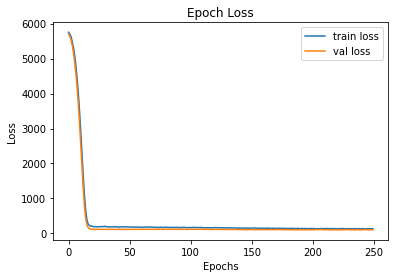

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_results)),train_loss_results, label='train loss')
plt.plot(range(len(val_loss_results)),val_loss_results, label='val loss')
plt.title('Epoch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png', dpi=500, transparent=True)
plt.show()

## Test Model And Show location for a few sets of images
The following cells are creating a hashmap of the centers of the grids to be used for predictions.

In [10]:
x_test, y_test, loc_test = next(iter(test_dataset))


In [11]:
def plot_pred(prediction,actual):
    import plotly.express as px
    import pandas as pd
    data = [
            [prediction[0].numpy(), prediction[1].numpy(), 'Predicted'],
            [actual[0].numpy(), actual[1].numpy(), 'Actual']
    ]
    df = pd.DataFrame(data, columns=[ 'Longitude','Latitude', 'Type'])
    fig = px.scatter_geo(df,lat='Latitude',lon='Longitude', color='Type')

    fig.update_layout(
      geo = dict(
          scope = 'north america',
          showland = True,
          landcolor = "rgb(212, 212, 212)",
          subunitcolor = "rgb(255, 255, 255)",
          countrycolor = "rgb(255, 255, 255)",
          showlakes = True,
          lakecolor = "rgb(255, 255, 255)",
          showsubunits = True,
          showcountries = True,
          resolution = 50,
          projection = dict(
              type = 'conic conformal',
              rotation_lon = -100
          ),
          lonaxis = dict(
              showgrid = True,
              gridwidth = 0.5,
              range= [ -140.0, -55.0 ],
              dtick = 5
          ),
          lataxis = dict (
              showgrid = True,
              gridwidth = 0.5,
              range= [ 20.0, 60.0 ],
              dtick = 5
          )
      ),
    )
    fig.show()

def combine_image(x):
    h,w = x.shape[1],x.shape[2]
    img = np.zeros((h,w*3,3))
    img[:,:w,:] = x[0,:,:,:]
    img[:,w:w*2,:] = x[1,:,:,:]
    img[:,w*2:,:] = x[2,:,:,:]
    return img


# Test a datapoint
One can use the following cell to test one of the datapoints in the validation data and see how close the predicted value was from the actual value on a grid.

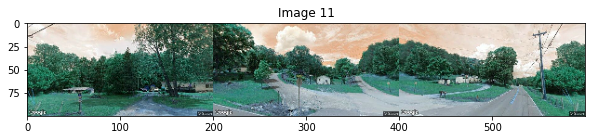

In [16]:
from PIL import Image
#Set i = <The validation datapoint>
i = 11
y_pred_reg = model(x_test[i][None,:], training=False)
plot_pred((y_pred_reg[0][1],y_pred_reg[0][0]),(loc_test[i][1],loc_test[i][0]))
plt.figure(figsize=(10,10))
plt.title(f'Image {i}')
plt.imshow(combine_image(x_test[i]))
plt.show()
Image.fromarray((combine_image(x_test[i])*255).astype(np.uint8)).save('ex_pred.png')

# Average Distance Error

The following cells get the averge distance in miles from the prediction was off from the actual location for training and testing.
There is an implementation of haversine distance which takes the earths curvature into account when calculating the distance between the two coordinates.


In [43]:
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import Polygon

def haversine(lati1, long1, lati2, long2):
    '''
    Gives distance in miles between two points on the planet specified by latitudes and longitudes
    lati1, long1: latitude and longitude of first location
    lati2, long2: latitude and longitude of second location
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    '''
    # approximate radius of earth in miles
    R = 3958.8

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lati1, long1, lati2, long2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [44]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


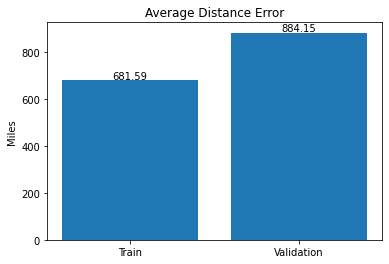

In [68]:
calc = lambda x, y: haversine(x[0], x[1], y[0], y[1])
train_dist = list(map(calc, train_pred, loc_train))
test_dist = list(map(calc, test_pred, loc_test))
avg_train = sum(train_dist)/ len(train_dist)
avg_test = sum(test_dist) / len(test_dist)

fig, ax = plt.subplots()
plt.title('Average Distance Error')
labels = ['Train', 'Validation']
bar = ax.bar(labels, [avg_train, avg_test])
plt.text(0,avg_train+5,f'{avg_train:0.2f}', ha = 'center')
plt.text(1, avg_test+5, f'{avg_test:0.2f}', ha = 'center')
plt.ylabel('Miles')
plt.savefig('avg_dist.png', dpi=500, transparent=True)
plt.show()

In [42]:
train_loss_results[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=135.9254>

# Comparing Against A Random Guess



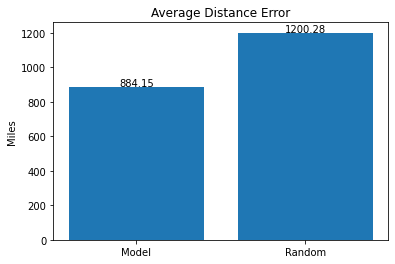

In [75]:
import random
from shapely.geometry import Polygon, Point
us_bounds = Polygon([(25, -125), (50, -125), (50, -70), (25, -75)])
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append([random_point.x, random_point.y])

    return points


random_points = random_points_within(us_bounds, len(X_test))
random_dist = list(map(calc, random_points, loc_test))
avg_random = sum(random_dist) / len(random_dist)


fig, ax = plt.subplots()
plt.title('Average Distance Error')
labels = ['Model', 'Random']

bar = ax.bar(labels, [avg_test, avg_random])
plt.text(0, avg_test+5, f'{avg_test:0.2f}', ha = 'center')
plt.text(1, avg_random+5, f'{avg_random:0.2f}', ha = 'center')
plt.ylabel('Miles')
plt.savefig('random_point_comparison.png', dpi=500, transparent=True)
plt.show()